In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE, RFECV , mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score , GridSearchCV , LeaveOneOut , KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score , make_scorer , classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.preprocessing import StandardScaler , LabelEncoder
from xgboost import XGBClassifier , plot_importance
from sklearn.utils import resample

In [2]:
dataWISC = pd.read_csv('dataWisc.csv')
dataWISC.drop(["Unnamed: 32"], axis = 1, inplace = True)
dataWISC

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
dataWiscTest = pd.read_csv('wpbc.csv' , header=None)
dataWiscTest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.10360,0.10860,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.11950,0.1926,0.3140,0.11700,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.16220,0.6656,0.7119,0.26540,0.4601,0.11890,3.0,2
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.11890,0.12550,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.11880,0.3449,0.3414,0.20320,0.4334,0.09067,2.5,0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.20980,0.8663,0.6869,0.25750,0.6638,0.17300,2.0,0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.13740,0.2050,0.4000,0.16250,0.2364,0.07678,3.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,942640,N,10,22.52,21.92,146.90,1597.0,0.07592,0.09162,0.06862,0.06367,0.1728,0.05262,1.3740,2.3120,9.938,192.40,0.004422,0.02679,0.02433,0.020360,0.02486,0.003922,24.67,24.81,162.10,1902.0,0.08191,0.1319,0.1056,0.09378,0.2061,0.05788,6.0,2
194,943471,N,8,15.44,31.18,101.00,740.4,0.09399,0.10620,0.13750,0.06500,0.1735,0.06105,0.3235,1.8390,1.971,32.61,0.006178,0.02088,0.02834,0.010790,0.02122,0.003168,17.34,41.48,112.60,929.0,0.12720,0.2362,0.2975,0.12860,0.2914,0.08024,1.5,0
195,94547,N,12,17.17,29.19,110.00,915.3,0.08952,0.06655,0.06583,0.05068,0.1793,0.05392,0.6101,1.4250,3.827,63.02,0.006890,0.01556,0.03155,0.009714,0.02734,0.001377,20.76,36.66,132.50,1295.0,0.12610,0.1572,0.2141,0.09520,0.3362,0.06033,3.7,0
196,947204,R,3,21.42,22.84,145.00,1440.0,0.10700,0.19390,0.23800,0.13180,0.1884,0.06472,1.0850,0.8469,8.308,142.50,0.006831,0.03541,0.04948,0.017700,0.01481,0.003979,28.34,27.98,198.30,2375.0,0.14980,0.4379,0.5411,0.22150,0.2832,0.08981,3.0,?


In [4]:
dataWiscTest.drop(dataWiscTest.columns[[2,33,34]], axis = 1, inplace = True)
dataWiscTest.columns = dataWISC.columns
dataWiscTest['diagnosis'] = dataWiscTest['diagnosis'].replace(['N','R'],['B','M'])
dataWiscTest

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,119513,B,18.02,27.60,117.50,1013.0,0.09489,0.10360,0.10860,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.11950,0.1926,0.3140,0.11700,0.2677,0.08113
1,8423,B,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.16220,0.6656,0.7119,0.26540,0.4601,0.11890
2,842517,B,21.37,17.44,137.50,1373.0,0.08836,0.11890,0.12550,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.11880,0.3449,0.3414,0.20320,0.4334,0.09067
3,843483,B,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.20980,0.8663,0.6869,0.25750,0.6638,0.17300
4,843584,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.13740,0.2050,0.4000,0.16250,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,942640,B,22.52,21.92,146.90,1597.0,0.07592,0.09162,0.06862,0.06367,0.1728,0.05262,1.3740,2.3120,9.938,192.40,0.004422,0.02679,0.02433,0.020360,0.02486,0.003922,24.67,24.81,162.10,1902.0,0.08191,0.1319,0.1056,0.09378,0.2061,0.05788
194,943471,B,15.44,31.18,101.00,740.4,0.09399,0.10620,0.13750,0.06500,0.1735,0.06105,0.3235,1.8390,1.971,32.61,0.006178,0.02088,0.02834,0.010790,0.02122,0.003168,17.34,41.48,112.60,929.0,0.12720,0.2362,0.2975,0.12860,0.2914,0.08024
195,94547,B,17.17,29.19,110.00,915.3,0.08952,0.06655,0.06583,0.05068,0.1793,0.05392,0.6101,1.4250,3.827,63.02,0.006890,0.01556,0.03155,0.009714,0.02734,0.001377,20.76,36.66,132.50,1295.0,0.12610,0.1572,0.2141,0.09520,0.3362,0.06033
196,947204,M,21.42,22.84,145.00,1440.0,0.10700,0.19390,0.23800,0.13180,0.1884,0.06472,1.0850,0.8469,8.308,142.50,0.006831,0.03541,0.04948,0.017700,0.01481,0.003979,28.34,27.98,198.30,2375.0,0.14980,0.4379,0.5411,0.22150,0.2832,0.08981


Number of Benign:  151
Number of Malignant :  47


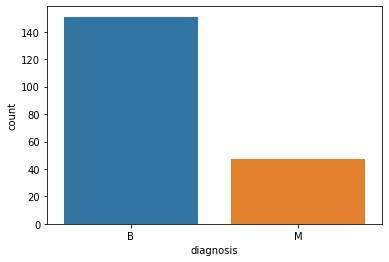

In [5]:
ax = sns.countplot(dataWiscTest['diagnosis'],label="Count",order=['B','M'])       # M = 47, B = 151
B, M = dataWiscTest['diagnosis'].value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

In [10]:
dataWiscTest.isin(dataWISC).sum()

id                          4
diagnosis                  93
radius_mean                 7
texture_mean                7
perimeter_mean              7
area_mean                   7
smoothness_mean             7
compactness_mean            7
concavity_mean              7
concave points_mean         7
symmetry_mean               7
fractal_dimension_mean      8
radius_se                   7
texture_se                  7
perimeter_se                8
area_se                     7
smoothness_se               7
compactness_se              7
concavity_se                7
concave points_se           7
symmetry_se                 7
fractal_dimension_se        7
radius_worst                7
texture_worst               8
perimeter_worst             7
area_worst                  7
smoothness_worst            8
compactness_worst           7
concavity_worst             7
concave points_worst        7
symmetry_worst              7
fractal_dimension_worst     7
dtype: int64